<a href="https://colab.research.google.com/github/Ved204/CP468-Facial-Recognition/blob/main/phase_one.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Facial Emotion Recognition

Project Configuration

In [40]:
# Import Libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import cv2
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.python.keras.utils.np_utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras.layers import Input,Activation,Add, BatchNormalization, MaxPool2D
from keras.models import Model
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow

In [2]:
# Mount Drive
from google.colab import drive
import os

drive.mount('/content/drive')
kaggle_json_path = '/content/drive/MyDrive/CP468 Project/kaggle.json'
# %cd '/content/drive/MyDrive/CP468 Project/dataset/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install Dataset
# !pip install kaggle
# ! mkdir ~/.kaggle
# ! cp {kaggle_json_path} ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download -d shuvoalok/ck-dataset
# ! unzip ck-dataset.zip

Pre-Process Data

In [41]:
# Define Variables to read folder names as variables
dataset_folder = '/content/drive/MyDrive/CP468 Project/dataset/input/'
sub_folders=os.listdir(dataset_folder)

i=0
last=[]
images=[]
labels=[]
original_labels = []
temp = sub_folders

In [ ]:
# Define the original 7 labels
original_label_mapping = {
    0: 'anger', 1: 'contempt', 2: 'disgust', 3: 'fear', 4: 'happy', 5: 'sadness', 6: 'surprise'
}

# Update the label encoding
images = []
labels = []
original_labels = []

for sub_folder in sub_folders:
    sub_folder_index = temp.index(sub_folder)
    label = sub_folder_index
    path = os.path.join(dataset_folder, sub_folder)
    sub_folder_images = os.listdir(path)

    for image in sub_folder_images:
        image_path = path + '/' + image
        print(image_path + "\t" + str(label))
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (48, 48))
        images.append(image)
        labels.append(label)
        original_labels.append(label)

In [58]:
# Preprocess Data
images_x = np.array(images)
labels_y = np.array(labels)
images_x = images_x / 255

# Encode Labels
num_of_classes = 7
labels_y_encoded = tf.keras.utils.to_categorical(labels_y, num_classes=num_of_classes)

In [59]:
# Split Dataset in 75% for Training and 25% for Testing
X_train, X_test, Y_train, Y_test = train_test_split(images_x, labels_y_encoded, test_size=0.25, random_state=10)

Data Analysis

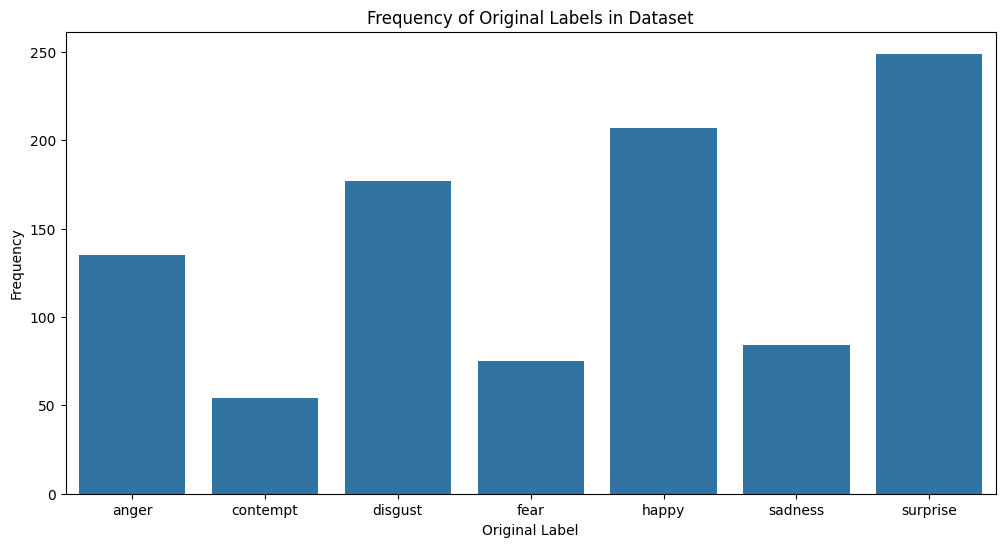

In [61]:
# Update the original label mapping for plotting
original_labels_mapped = [original_label_mapping[label] for label in original_labels]
original_labels_df = pd.DataFrame({'original_label': original_labels_mapped})

# Plot the frequency of original labels
plt.figure(figsize=(12, 6))
sns.countplot(x='original_label', data=original_labels_df, order=list(original_label_mapping.values()))
plt.title('Frequency of Original Labels in Dataset')
plt.xlabel('Original Label')
plt.ylabel('Frequency')
plt.show()

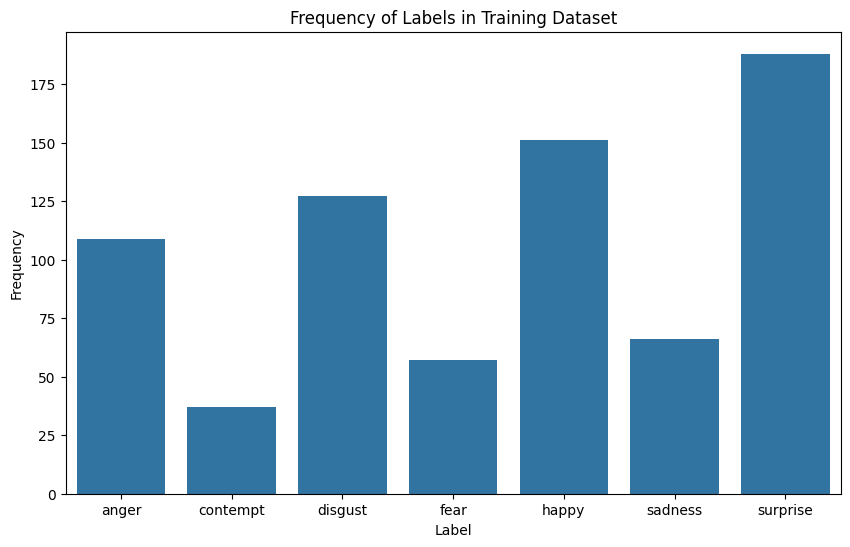

In [62]:
# Plotting Frequency of Labels in training dataset
Y_train_labels = np.argmax(Y_train, axis=1)
Y_train_labels_mapped = [original_label_mapping[label] for label in Y_train_labels]
train_df = pd.DataFrame({'label': Y_train_labels_mapped})

plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=train_df, order=list(original_label_mapping.values()))
plt.title('Frequency of Labels in Training Dataset')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

In [63]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Function to load images from each subfolder
def load_images_from_folder(folder, num_images=3):
    images = []
    for filename in os.listdir(folder)[:num_images]:  # Load only the first `num_images` images
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path) and img_path.endswith('.png'):
            img = mpimg.imread(img_path)
            images.append(img)
    return images

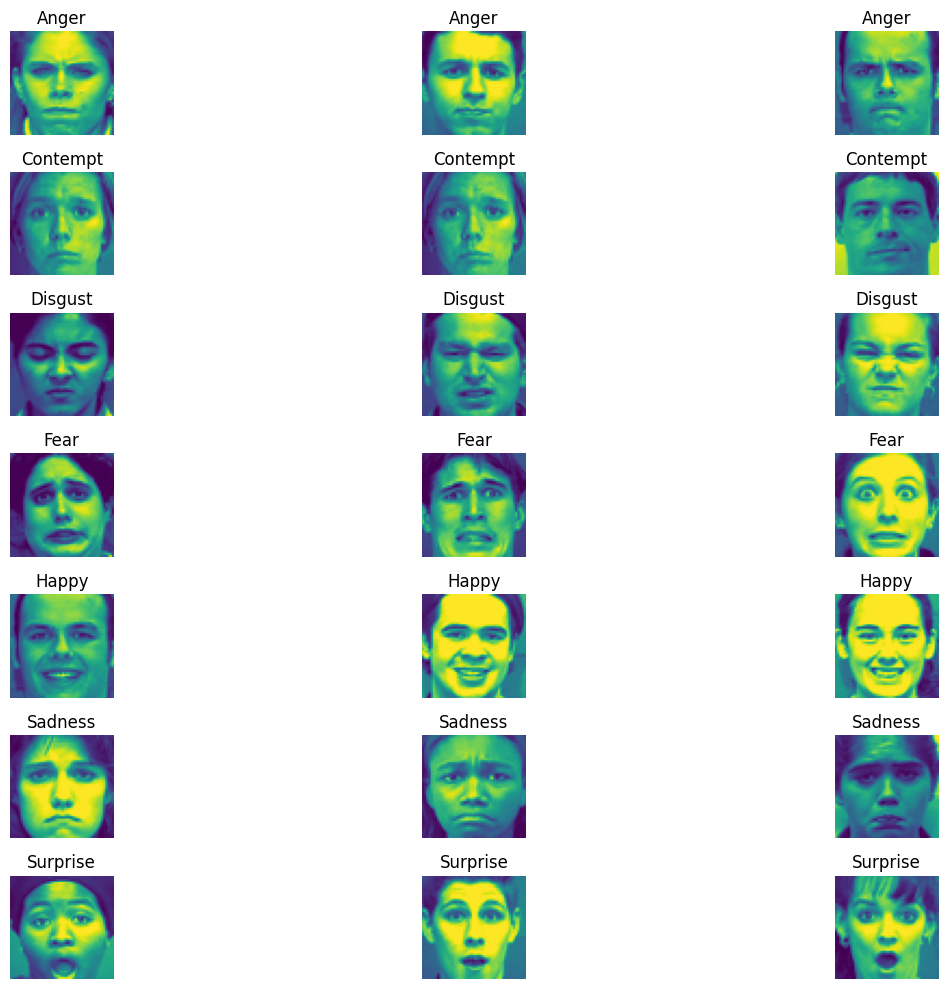

In [64]:
# Load a few images from each emotion subfolder
emotion_images = {emotion: load_images_from_folder(os.path.join(dataset_folder, emotion)) for emotion in sub_folders}

# Display the images in a grid
num_images_per_row = 3
plt.figure(figsize=(15, 10))

for i, (emotion, images) in enumerate(emotion_images.items()):
    for j, img in enumerate(images):
        plt.subplot(len(sub_folders), num_images_per_row, i * num_images_per_row + j + 1)
        plt.imshow(img)
        plt.title(f"{emotion.capitalize()}")
        plt.axis('off')

plt.tight_layout()
plt.show()

Build CNN Architecture

In [65]:
input = Input(shape=(48, 48, 1))
conv1 = Conv2D(32, (3, 3), padding='same', strides=(1, 1), kernel_regularizer=l2(0.001))(input)
conv1 = Dropout(0.1)(conv1)
conv1 = Activation('relu')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), padding='same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool1)
conv2 = Dropout(0.1)(conv2)
conv2 = Activation('relu')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, (3, 3), padding='same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool2)
conv3 = Dropout(0.1)(conv3)
conv3 = Activation('relu')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(256, (3, 3), padding='same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool3)
conv4 = Dropout(0.1)(conv4)
conv4 = Activation('relu')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
flatten = Flatten()(pool4)
dense_1 = Dense(128, activation='relu')(flatten)
drop_1 = Dropout(0.2)(dense_1)
output = Dense(7, activation="softmax")(drop_1)  # Updated to 7 classes

# Model compile
model = Model(inputs=input, outputs=output)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])
model.summary()

# Configure Model Checkpoint
fle_s = '/content/drive/MyDrive/CP468 Project/dataset/output/emotion_model.h5'
checkpointer = ModelCheckpoint(fle_s, monitor='loss', verbose=1, save_best_only=True,
                               save_weights_only=False, mode='auto', save_freq='epoch')
callback_list = [checkpointer]

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 dropout_20 (Dropout)        (None, 48, 48, 32)        0         
                                                                 
 activation_16 (Activation)  (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 24, 24, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 24, 24, 64)        18496     
                                                           

Model Training

In [66]:
save = model.fit(X_train, Y_train, batch_size=32, validation_data=(X_test, Y_test), epochs=50, callbacks=[callback_list])

Epoch 1/50
19/23 [=======================>......] - ETA: 0s - loss: 2.1301 - accuracy: 0.2105
Epoch 1: loss improved from inf to 2.10999, saving model to /content/drive/MyDrive/CP468 Project/dataset/output/emotion_model.h5
23/23 [==============================] - 3s 54ms/step - loss: 2.1100 - accuracy: 0.2218 - val_loss: 2.0091 - val_accuracy: 0.2480
Epoch 2/50
22/23 [===========================>..] - ETA: 0s - loss: 1.9678 - accuracy: 0.2514
Epoch 2: loss improved from 2.10999 to 1.97248, saving model to /content/drive/MyDrive/CP468 Project/dataset/output/emotion_model.h5
23/23 [==============================] - 0s 13ms/step - loss: 1.9725 - accuracy: 0.2476 - val_loss: 1.9048 - val_accuracy: 0.4512
Epoch 3/50
17/23 [=====================>........] - ETA: 0s - loss: 1.9241 - accuracy: 0.2739
Epoch 3: loss improved from 1.97248 to 1.89139, saving model to /content/drive/MyDrive/CP468 Project/dataset/output/emotion_model.h5
23/23 [==============================] - 0s 12ms/step - loss: 1

In [102]:
model.save('/content/drive/MyDrive/CP468 Project/dataset/output/emotion_model_output.h5')

Analyze and Plot Results

Text(0.5, 0.92, 'Lineplots showing loss and accuracy of CNN model by epochs')

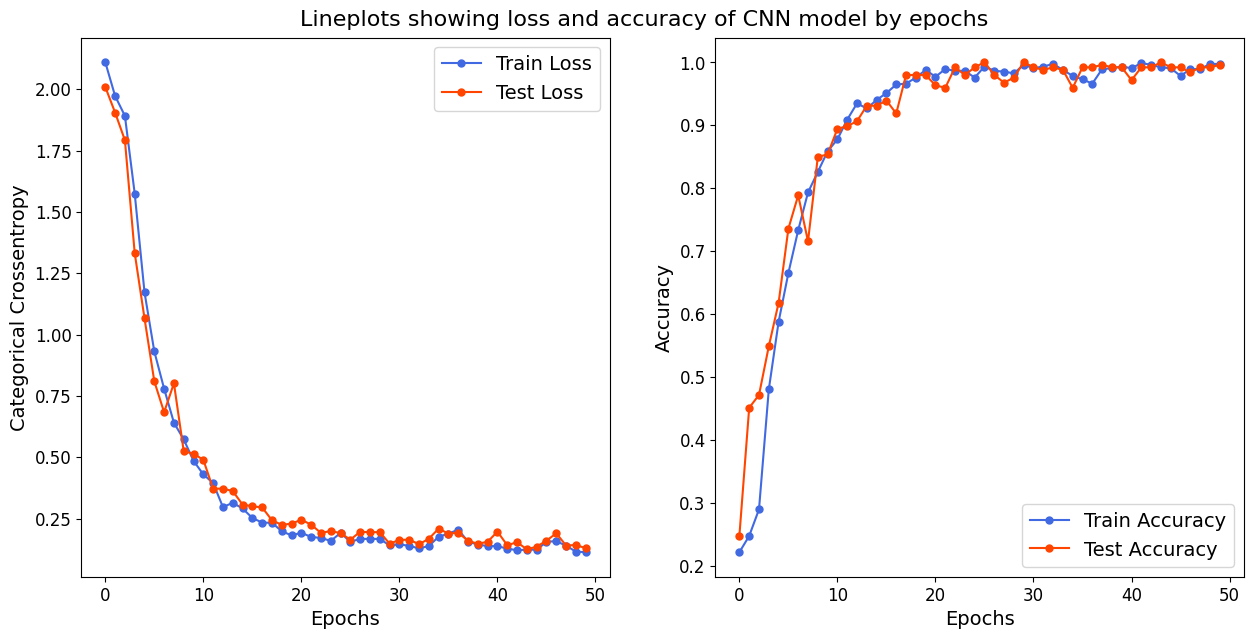

In [67]:
# Accuracy and Loss Graph
train_loss = save.history['loss']
test_loss = save.history['val_loss']
train_accuracy = save.history['accuracy']
test_accuracy = save.history['val_accuracy']

fig, ax = plt.subplots(ncols=2, figsize=(15, 7))
ax = ax.ravel()
ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color='orangered', marker='o', markersize=5)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)
ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)
fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)

8/8 [==============================] - 0s 3ms/step


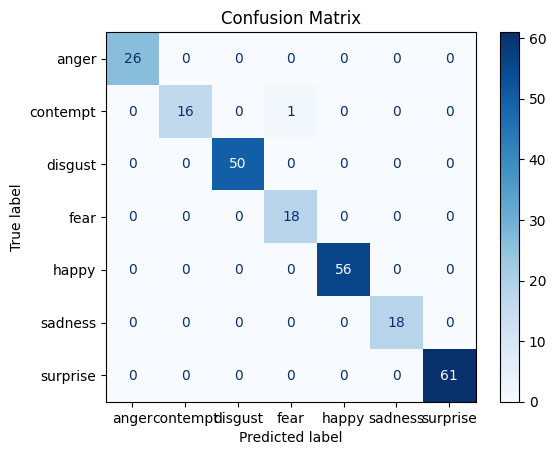

In [99]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Ensure correct shape for X_test
X_test_reshaped = X_test.reshape(-1, 48, 48, 1)

# Predict the test data
y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(original_label_mapping.values()))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [100]:
from sklearn.metrics import classification_report

# Ensure correct shape for X_test
X_test_reshaped = X_test.reshape(-1, 48, 48, 1)

# Evaluate on test data
test_loss, test_acc = model.evaluate(X_test_reshaped, Y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}')

# Predict on test data
y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)

# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=list(original_label_mapping.values())))


8/8 [==============================] - 0s 4ms/step - loss: 0.1292 - accuracy: 0.9959
Test Loss: 0.12918686866760254, Test Accuracy: 0.9959349632263184
8/8 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

       anger       1.00      1.00      1.00        26
    contempt       1.00      0.94      0.97        17
     disgust       1.00      1.00      1.00        50
        fear       0.95      1.00      0.97        18
       happy       1.00      1.00      1.00        56
     sadness       1.00      1.00      1.00        18
    surprise       1.00      1.00      1.00        61

    accuracy                           1.00       246
   macro avg       0.99      0.99      0.99       246
weighted avg       1.00      1.00      1.00       246



Testing

1/1 [==============================] - 0s 18ms/step
Original Output: anger
Predicted Output: anger


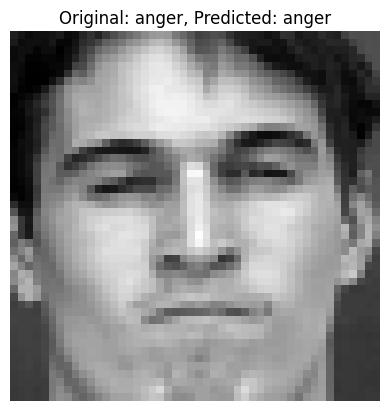

In [87]:
# Test with Random Image
image_index = random.randint(0, len(X_test) - 1)
original_label = original_label_mapping[np.argmax(Y_test[image_index])]
pred = model.predict(X_test[image_index].reshape(1, 48, 48, 1))
prediction_label = original_label_mapping[pred.argmax()]
print(f"Original Output: {original_label}")
print(f"Predicted Output: {prediction_label}")

# Display the image
plt.imshow(X_test[image_index].reshape(48, 48), cmap='gray')
plt.title(f"Original: {original_label}, Predicted: {prediction_label}")
plt.axis('off')
plt.show()

Saving istockphoto-1146642361-612x612.jpg to istockphoto-1146642361-612x612.jpg
1/1 [==============================] - 0s 17ms/step


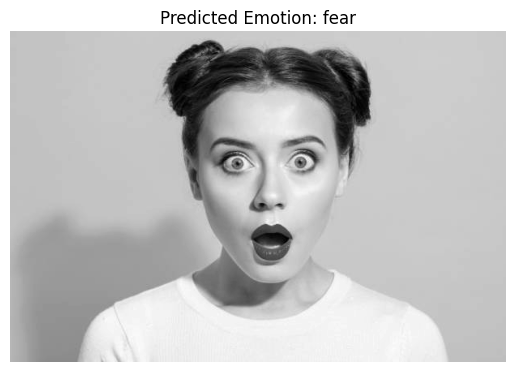

In [81]:
# Upload Random Image
from google.colab import files

# Function to preprocess the uploaded image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (48, 48))
    image = image / 255.0
    return image.reshape(1, 48, 48, 1)

# Function to upload an image and predict the emotion
def upload_and_predict_emotion(model):
    # Upload an image
    uploaded = files.upload()

    for image_name in uploaded.keys():
        # Preprocess the image
        preprocessed_image = preprocess_image(image_name)

        # Predict the emotion
        prediction = model.predict(preprocessed_image)
        predicted_label = original_label_mapping[np.argmax(prediction)]

        # Display the image and the prediction
        image = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)
        plt.imshow(image, cmap='gray')
        plt.title(f"Predicted Emotion: {predicted_label}")
        plt.axis('off')
        plt.show()

# Use the function to upload an image and get the prediction
upload_and_predict_emotion(model)


Saving 1000_F_203184817_IXyq2BIm0Bylm3LpymGVCkAIVgq8rJL0.jpg to 1000_F_203184817_IXyq2BIm0Bylm3LpymGVCkAIVgq8rJL0.jpg
1/1 [==============================] - 0s 19ms/step


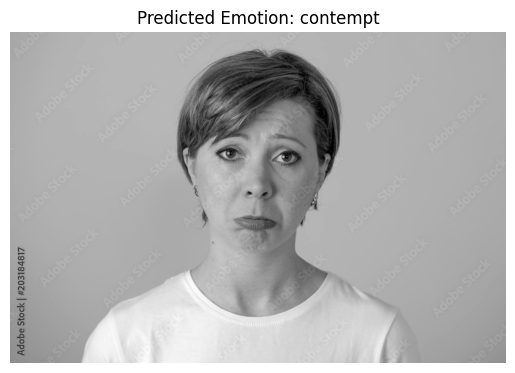

In [92]:
# Test 2
upload_and_predict_emotion(model)

Saving angry face.jpg to angry face.jpg
1/1 [==============================] - 0s 17ms/step


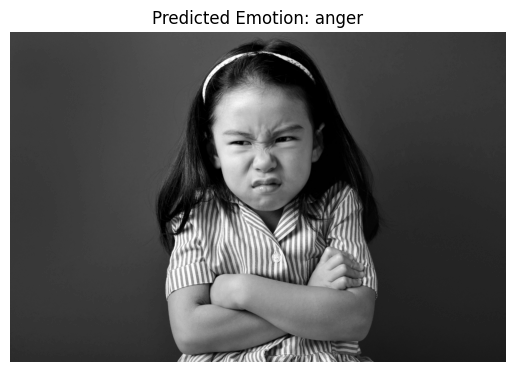

In [89]:
# Test 3
upload_and_predict_emotion(model)